# Imports

In [1]:
import os
import pathlib

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

# Load data

In [2]:
# Set image size and batch size. Tunable hyper-parameters. 
IMG_SIZE = 64
BATCH_SIZE = 128
# Mean, std for normalising images to [-1, 1] from [0, 1]. i.e. Subtract mean of 0.5, then divide by std of 0.5. 
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) 

((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

In [3]:
# Note: Download via PyTorch datasets is not available. 
# Download directly from http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html.
# To load data via PyTorch datasets, the files must be extracted into a data_dir with the following structure
# .
# ├── celeba
# │   ├── identity_CelebA.txt
# │   ├── img_align_celeba
# │   │   ├── 000001.jpg
# │   │   ...
# │   │   └── 202599.jpg
# │   ├── list_attr_celeba.txt
# │   ├── list_bbox_celeba.txt
# │   ├── list_eval_partition.txt
# │   ├── list_landmarks_align_celeba.txt
# │   ├── list_landmarks_celeba.txt
# │   └── README.txt

data_dir = pathlib.Path.cwd().parent/'data'
transforms = T.Compose([T.Resize(IMG_SIZE),
                        T.CenterCrop(IMG_SIZE), #  Central square crop
                        T.ToTensor(),
                        T.Normalize(*stats) # normalize => mean 0 std 1                              
                        ])       
celeb_data = torchvision.datasets.CelebA(data_dir, split = 'all', transform = transforms)

Dataset CelebA
    Number of datapoints: 202599
    Root location: /home/mayank-soni/code/mayank-soni/AIAP/dsgan/data
    Target type: ['attr']
    Split: all
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [4]:
celeb_dl = torch.utils.data.DataLoader(celeb_data, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True) 

## View images

In [5]:
# Utilities for viewing images in a grid

def denorm(img_tensors):
    """Denormalise image tensor with specified mean and std
    Go from [-1, 1] to [0, 1] for each pixel i.e. multiply by 0.5, then add 0.5. 
    """
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(torchvision.utils.make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
  
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

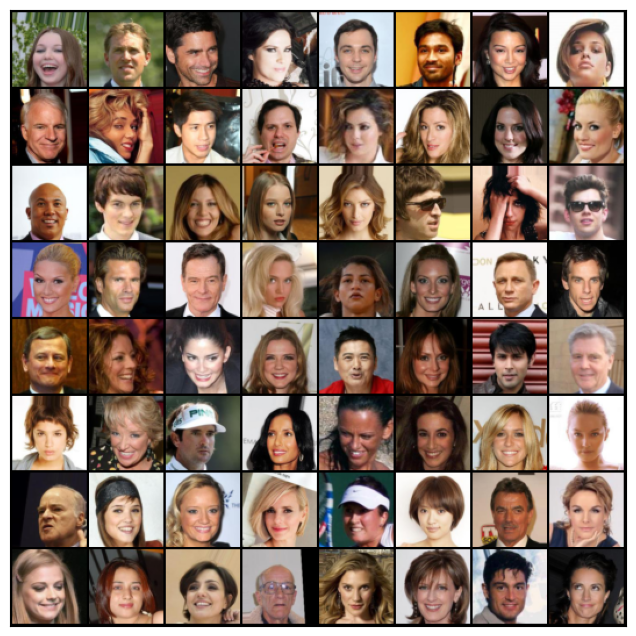

In [6]:
show_batch(celeb_dl)

# Build GAN

## Move dataloader to GPU (if available)

In [7]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [8]:
device = get_default_device()

device(type='cuda')

In [9]:
train_dl = DeviceDataLoader(celeb_dl, device)

## Discriminator network

In [10]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    # out: dimension 1 (logit)
    
    nn.Sigmoid()
    # out: dimension 1 (probability)
)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Flatten(s

In [11]:
discriminator = to_device(discriminator, device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Flatten(s

In [12]:
# Check sizes of images as they pass through discriminator
# create a tensor Batch_Size = 2,C,H,W
X = torch.rand(size=(2, 3, 64, 64), dtype=torch.float32, device=device) 
for layer in discriminator:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t', X.shape)

Conv2d output shape: 	 torch.Size([2, 64, 32, 32])
BatchNorm2d output shape: 	 torch.Size([2, 64, 32, 32])
LeakyReLU output shape: 	 torch.Size([2, 64, 32, 32])
Conv2d output shape: 	 torch.Size([2, 128, 16, 16])
BatchNorm2d output shape: 	 torch.Size([2, 128, 16, 16])
LeakyReLU output shape: 	 torch.Size([2, 128, 16, 16])
Conv2d output shape: 	 torch.Size([2, 256, 8, 8])
BatchNorm2d output shape: 	 torch.Size([2, 256, 8, 8])
LeakyReLU output shape: 	 torch.Size([2, 256, 8, 8])
Conv2d output shape: 	 torch.Size([2, 512, 4, 4])
BatchNorm2d output shape: 	 torch.Size([2, 512, 4, 4])
LeakyReLU output shape: 	 torch.Size([2, 512, 4, 4])
Conv2d output shape: 	 torch.Size([2, 1, 1, 1])
Flatten output shape: 	 torch.Size([2, 1])
Sigmoid output shape: 	 torch.Size([2, 1])


## Generator network

In [13]:
# Size of latent space. Tunable. 
LATENT_SIZE = 128

128

In [14]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(LATENT_SIZE, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()  # output is between -1 to 1
    # out: 3 x 64 x 64
)

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

In [15]:
# Check sizes of images as they pass through generator
# create a tensor Batch_Size = 2,latent size, 1, 1
X = torch.randn(size=(2, 128, 1, 1))
for layer in generator:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

ConvTranspose2d output shape: 	 torch.Size([2, 512, 4, 4])
BatchNorm2d output shape: 	 torch.Size([2, 512, 4, 4])
ReLU output shape: 	 torch.Size([2, 512, 4, 4])
ConvTranspose2d output shape: 	 torch.Size([2, 256, 8, 8])
BatchNorm2d output shape: 	 torch.Size([2, 256, 8, 8])
ReLU output shape: 	 torch.Size([2, 256, 8, 8])
ConvTranspose2d output shape: 	 torch.Size([2, 128, 16, 16])
BatchNorm2d output shape: 	 torch.Size([2, 128, 16, 16])
ReLU output shape: 	 torch.Size([2, 128, 16, 16])
ConvTranspose2d output shape: 	 torch.Size([2, 64, 32, 32])
BatchNorm2d output shape: 	 torch.Size([2, 64, 32, 32])
ReLU output shape: 	 torch.Size([2, 64, 32, 32])
ConvTranspose2d output shape: 	 torch.Size([2, 3, 64, 64])
Tanh output shape: 	 torch.Size([2, 3, 64, 64])


torch.Size([128, 3, 64, 64])


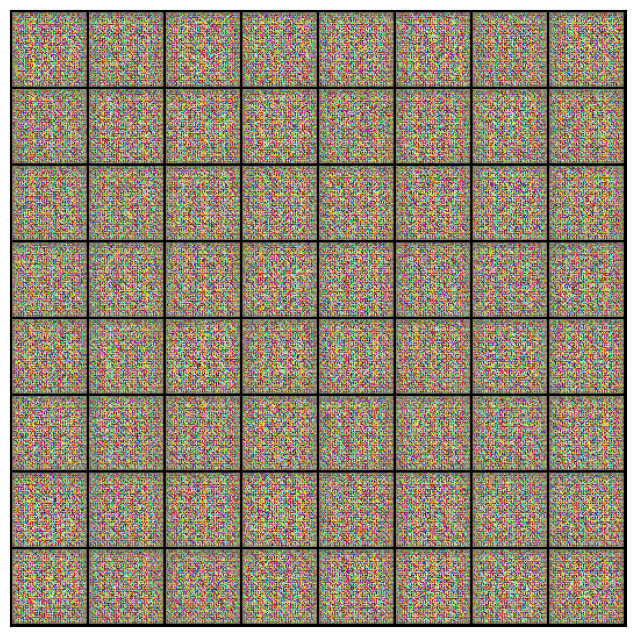

In [16]:
xb = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1) # random latent tensors for generation
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [17]:
generator = to_device(generator, device) # move generator to device

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

# Training

In [18]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass batch of real images through discriminator
    real_preds = discriminator(real_images)
    # Target = 1 i.e. real
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    # mean predicted probability of images being real (i.e. higher is better for discriminator)
    real_score = torch.mean(real_preds).item() 

    # Generate batch of artificial images
    latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    # Target = 0 i.e. fake
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    # average probability predicted for artificial images to be real (i.e. higher is better for generator)
    fake_score = torch.mean(fake_preds).item() 
    
    # Update discriminator weights based on sum of loss on real and artificial batch (i.e. sum of gradients)
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [19]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate batch of fake images
    latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1,1, device=device)
    fake_images = generator(latent)

    # Target set at 1 (even though images are fake), since we are training generator. 
    # So a prediction of 1 is good, and a prediction of 0 is bad. 
    preds = discriminator(fake_images)
    targets = torch.ones(BATCH_SIZE, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator. opt_g does not change discriminator weights even though they also have gradients. 
    loss.backward()
    opt_g.step()

    return loss.item()

## Create intermediate output folder

In [20]:
sample_dir = data_dir / 'generated_trial' 
os.makedirs(sample_dir, exist_ok=True)

# Util function for saving a sample of generated images.
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated=images-{0:0=4d}.png'.format(index)
    torchvision.utils.save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print("Saving", fake_fname)

    if show:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(torchvision.utils.make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [21]:
# Fixed set of latent tensors used to generate images for saving - to see progression in same image across epochs. 
fixed_latent = torch.randn(64, LATENT_SIZE, 1, 1, device=device);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated=images-0000.png


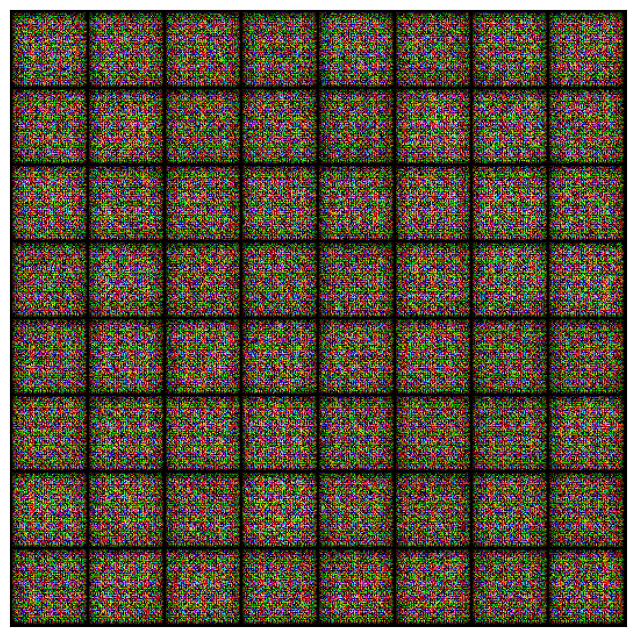

In [22]:
save_samples(0, fixed_latent)

## Training

In [23]:
# Hyperparameters. Tunable.
LR = 0.00025
EPOCHS = 60;

In [24]:
def checkpoint(model, model_dir, filename):
    torch.save(model.state_dict(), model_dir/filename)

In [25]:
model_dir = pathlib.Path.cwd().parent / 'models_trial'
os.makedirs(model_dir, exist_ok=True)

In [26]:
def fit(epochs, lr, checkpoint_dir, start_idx = 1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimisers, one for each model. 
    # Set beta1 at 0.5 (default 0.9) to increase momentum and reduce likelihood of being stuck in local minimum. 
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        # We don't use the second element in each batch, which represents metadata
        for index, (real_images, _) in enumerate(tqdm(train_dl)):
            # Train discriminator for one cycle
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator for one cycle
            loss_g = train_generator(opt_g)

            # Record losses & scores
            losses_g.append(loss_g) # generator loss
            losses_d.append(loss_d) # discriminator loss
            real_scores.append(real_score) # discriminator avg probability on real data (higher is better score for discriminator)
            fake_scores.append(fake_score) # discriminator avg probability on fake data (higher is better score for generator)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(epoch+1, epochs, index, len(train_dl), loss_g, loss_d, real_score, fake_score))
        # Save model weights and generated images after each epoch
        checkpoint(generator, checkpoint_dir, f'Generator_{epoch+1}')
        checkpoint(discriminator, checkpoint_dir, f'Discriminator_{epoch+1}')
        save_samples(epoch+start_idx, fixed_latent, show=False)
        
    return losses_g, losses_d, real_scores, fake_scores

In [27]:
history = fit(EPOCHS, LR, model_dir)

  0%|          | 0/1583 [00:00<?, ?it/s]

ValueError: not enough values to unpack (expected 4, got 3)